In [1]:
from planet import api
from planet.api import filters
from sys import stdout
import urllib.request
import shutil
from requests.auth import HTTPBasicAuth
import os
import time
import requests
import cv2
import glob
import subprocess
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = api.ClientV1('219bc2e637384268a2d606dd8c05e7a7') 
PL_API_KEY = '219bc2e637384268a2d606dd8c05e7a7'

In [3]:
geo_json_geometry = {
  "type": "Polygon",
        "coordinates": [
          [
            [
              105.35270690917969,
              -6.117683645476741
            ],
            [
              105.47595977783203,
              -6.117683645476741
            ],
            [
              105.47595977783203,
              -6.068183062989519
            ],
            [
              105.35270690917969,
              -6.068183062989519
            ],
            [
              105.35270690917969,
              -6.117683645476741
            ]
          ]
        ]
      }

In [4]:
geometry_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": geo_json_geometry
}

In [5]:
date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gte": "2018-11-04T00:00:00.000Z",
        "lte": "2018-11-20T00:00:00.000Z"
    }
}

In [6]:
cloud_cover_filter = {
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lte": 0.2,
    }
}

In [7]:
item_types = ['PSScene3Band']
asset_type = 'visual'

In [8]:
query = {
    "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [9]:
request = filters.build_search_request(
    query, item_types
)

In [10]:
dataset = client.quick_search(request)

stdout.write('id,cloud_cover,date\n')

id,cloud_cover,date


In [11]:
for item in dataset.items_iter(limit=None):
    props = item['properties']
    stdout.write('{0},{cloud_cover},{acquired}\n'.format(item['id'], **props))

20181117_024659_0e20,0.01,2018-11-17T02:46:59.204854Z
20181117_024700_0e20,0.03,2018-11-17T02:47:00.242945Z
20181117_024701_0e20,0.02,2018-11-17T02:47:01.281035Z
20181116_025054_1008,0.01,2018-11-16T02:50:54.635364Z
20181116_025053_1008,0,2018-11-16T02:50:53.588885Z
20181116_031617_1049,0,2018-11-16T03:16:17.773752Z
20181116_031618_1049,0,2018-11-16T03:16:18.753122Z
20181116_031619_1049,0,2018-11-16T03:16:19.733016Z
20181106_031758_0f49,0.02,2018-11-06T03:17:58.450347Z
20181106_031759_0f49,0.19,2018-11-06T03:17:59.42028Z


In [12]:
for i in item_types:
    request = api.filters.build_search_request(query, [i])  # ,name = None, interval= 'day')
    dataset = client.quick_search(request)
    print(i)
    for item in dataset.items_iter(limit=4):
        print(item['id'])
        session = requests.Session()
        session.auth = (PL_API_KEY, '')
        results = \
            session.get(
                ("https://api.planet.com/data/v1/item-types/" +
                 "{}/items/{}/assets/").format(i, item['id']))
       
        item_activation_url = results.json()[asset_type]["_links"]["activate"]
       
        response = session.post(item_activation_url)
        print(response.status_code)
        while response.status_code != 204:
            time.sleep(30)
            response = session.post(item_activation_url)
            response.status_code = response.status_code
            print(response.status_code)
        
        item_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(i, item['id'])
        result = requests.get(item_url, auth=HTTPBasicAuth(PL_API_KEY, ''))
        download_url = result.json()[asset_type]['location']  # KeyError: 'location'
        output_file = item['id'] + '.tif'

        with urllib.request.urlopen(download_url) as response, open(output_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

PSScene3Band
20181117_024659_0e20
204
20181117_024700_0e20
204
20181117_024701_0e20
204
20181116_025054_1008
204


In [13]:
os.getcwd()
os.mkdir('Original_Ash_Imagery')

In [14]:
sp = '/Users/joshuatokunaga/Desktop/Original_Ash_Imagery'
sf = os.listdir(sp)
dp = '/Users/joshuatokunaga/Desktop/Original_Ash_Imagery'
for file in sf:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp,file), os.path.join(dp, file))

In [15]:
images = [f for f in os.listdir(dp) if os.path.isfile(os.path.join(dp, f))]

for image in images:
    folder_name = image.split('_')[0]

    new_path = os.path.join(dp, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(dp, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

In [16]:
folders = []
for r, d, f in os.walk(dp):
    for folder in d:
        folders.append(os.path.join(r, folder))

i = 0
for x in folders:
    files_to_mosaic = glob.glob(folders[i] + '/*.tif')
    files_string = " ".join(files_to_mosaic)
    command = "python /Users/joshuatokunaga/Desktop/Merge_Test/gdal_merge.py -o " + files_string[-33:-25] + ".tif" + " -of gtiff " + files_string
    print(command)
    i = i + 1
    output = subprocess.getoutput(command)
    print(output)

python /Users/joshuatokunaga/Desktop/Merge_Test/gdal_merge.py -o .tif -of gtiff 
No input files selected.
Usage: gdal_merge.py [-o out_filename] [-of out_format] [-co NAME=VALUE]*
                     [-ps pixelsize_x pixelsize_y] [-tap] [-separate] [-q] [-v] [-pct]
                     [-ul_lr ulx uly lrx lry] [-init "value [value...]"]
                     [-n nodata_value] [-a_nodata output_nodata_value]
                     [-ot datatype] [-createonly] input_files
                     [--help-general]

python /Users/joshuatokunaga/Desktop/Merge_Test/gdal_merge.py -o 20181116.tif -of gtiff /Users/joshuatokunaga/Desktop/Original_Ash_Imagery/20181116/20181116_025054_1008.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
python /Users/joshuatokunaga/Desktop/Merge_Test/gdal_merge.py -o 20181117.tif -of gtiff /Users/joshuatokunaga/Desktop/Original_Ash_Imagery/20181117/20181117_024659_0e20.tif /Users/joshuatokunaga/Desktop/Original_Ash_Imagery/20181117/20181117_024701_0e20.

In [17]:
os.mkdir('Merged_Ash_Tifs')

In [18]:
sp = '/Users/joshuatokunaga/Desktop/Merged_Ash_Tifs'
sf = os.listdir(sp)
dp = '/Users/joshuatokunaga/Desktop/Merged_Ash_Tifs'
for file in sf:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp,file), os.path.join(dp, file))

In [19]:
os.chdir('/Users/joshuatokunaga/Desktop/Merged_Ash_Tifs')

In [20]:
flags = [i for i in dir(cv2) if i.startswith('COLOR')]

In [21]:
len(flags)

295

In [22]:
flags[40]

'COLOR_BAYER_GR2BGRA'

In [23]:
planet = cv2.imread('20181117.tif')

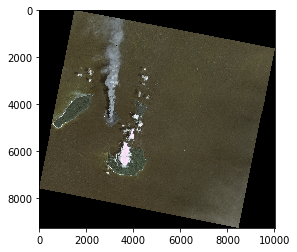

In [24]:
plt.imshow(planet)

In [25]:
planet2 = cv2.cvtColor(planet, cv2.COLOR_BGRA2RGBA)

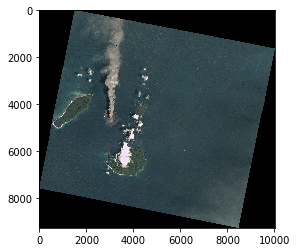

In [26]:
plt.imshow(planet2)

In [27]:
range1_lo = (130, 130, 89, 255)
range1_hi = (166, 152, 129, 255)

In [28]:
mask_range1 = cv2.inRange(planet2, range1_lo, range1_hi)

In [29]:
range2_lo = (153, 146, 137, 255)
range2_hi = (219, 208, 195, 255)

In [30]:
mask_range2 = cv2.inRange(planet2, range2_lo, range2_hi)

In [31]:
range3_lo = (120, 119, 114, 255)
range3_hi = (125, 126, 121, 255)

In [32]:
mask_range3 = cv2.inRange(planet2, range3_lo, range3_hi)

In [33]:
range4_lo = (144, 144, 129, 255)
range4_hi = (150, 150, 137, 255)

In [34]:
mask_range4 = cv2.inRange(planet2, range4_lo, range4_hi)

In [35]:
ash_mask = mask_range1+mask_range2+mask_range3+mask_range4

In [36]:
ash_result = cv2.bitwise_and(planet2, planet2, mask=ash_mask)

<function matplotlib.pyplot.show(*args, **kw)>

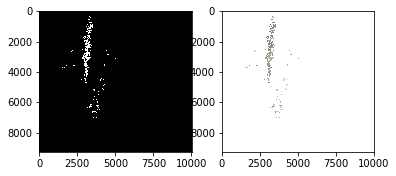

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(ash_mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ash_result)
plt.show

In [38]:
#Creates tif file of red-highlighted ash w/white background
ash_result[ash_mask>0]=(0,0,255,255)
cv2.imwrite("MergedTifTest.tif",ash_result)

True

In [39]:
planet[ash_mask>0]=(0,0,255)

In [40]:
#Creates tif file of red-highlighted ash w/original background
cv2.imwrite("MergedResult.tif",planet)

True